In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


# Set batch size for training and validation
batch_size = 32

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import splitfolders
from keras.preprocessing import image

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/cvice', output="output",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 689 files [00:34, 20.13 files/s]


In [ ]:
def preprocess_data(batch_size, img_size):
  #train_gen = image.ImageDataGenerator(rescale = 1./255.)
  train_gen = image.ImageDataGenerator(rescale = 1./255.,
                                      rotation_range=25,
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.25,
                                      zoom_range = 0.3,
                                      horizontal_flip = True,
                                      vertical_flip= True
                                     )
  train_generator = train_gen.flow_from_directory(
                                      "/content/output/train",
                                      target_size = img_size,
                                      class_mode = "categorical",
                                      shuffle = True,
                                      batch_size = batch_size
                                      )
  val_datagen = image.ImageDataGenerator(rescale = 1./255.)
  val_generator = val_datagen.flow_from_directory("/content/output/val",
                                         target_size = img_size,
                                         class_mode = 'categorical',
                                         batch_size=batch_size,
                                         shuffle = False)
  test_datagen = image.ImageDataGenerator(rescale = 1./255.)
  test_generator = test_datagen.flow_from_directory("/content/output/test",
                                         target_size = img_size,
                                         class_mode = 'categorical',
                                         batch_size=batch_size,
                                         shuffle= False)
  return train_generator,val_generator,test_generator

In [ ]:
train_processed_224, validation_processed_224, test_processed_224 = preprocess_data(batch_size, img_size=[224,224])
train_processed_299, validation_processed_299, test_processed_299 = preprocess_data(batch_size, img_size=[299,299])

Found 472 images belonging to 20 classes.
Found 93 images belonging to 20 classes.
Found 124 images belonging to 20 classes.
Found 472 images belonging to 20 classes.
Found 93 images belonging to 20 classes.
Found 124 images belonging to 20 classes.


In [ ]:
num_train =train_processed_224.samples
num_validation =  validation_processed_224.samples
num_classes = len(list( validation_processed_224.class_indices.keys()))
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 472         
Num validation images: 93         
Num classes: 20         
Num iterations per epoch: 14


In [ ]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
new_model_dict = {key: model_dictionary[key] for key in model_dictionary  if key in ['ResNet50V2','ResNet101V2']}

Rezultat za sve 3, 10 epoha:

In [ ]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': [], 'test_accuracy': []}
for model_name, model in tqdm(new_model_dict.items()):
    if 'Xception' in model_name:
        input_shape=(299,299,3)
        train_processed = train_processed_299
        validation_processed = validation_processed_299
        test_processed = test_processed_299
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        test_processed = test_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=10, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)
    test_acc = clf_model.evaluate(test_processed)
    predictions = clf_model.predict(test_processed)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_processed.classes
    class_labels = list(test_processed.class_indices.keys())

    report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10
14/14 [==============================] - 173s 12s/step - loss: 2.9843 - accuracy: 0.1591 - val_loss: 2.1067 - val_accuracy: 0.3441
Epoch 2/10
14/14 [==============================] - 142s 10s/step - loss: 2.0690 - accuracy: 0.4045 - val_loss: 1.5288 - val_accuracy: 0.5376
Epoch 3/10
14/14 [==============================] - 139s 10s/step - loss: 1.6224 - accuracy: 0.5545 - val_loss: 1.2346 - val_accuracy: 0.6237
Epoch 4/10
14/14 [==============================] - 139s 10s/step - loss: 1.3693 - accuracy: 0.6273 - val_loss: 1.0673 - val_accuracy: 0.6882
Epoch 5/10
14/14 [==============================] - 140s 10s/step - loss: 1.1765 - accuracy: 0.6909 - val_loss: 0.9523 - val_accuracy: 0.7312
Epoch 6/10
14/14 [==============================] - 139s 10s/step - loss: 1.0867 - accuracy: 0.6818 - val_loss: 0.8709 - val_accuracy: 0.7849
Epoch 7/10
14/14 [==============================] - 140s 10s/step - loss: 0.9509 - accuracy: 0.7682 - val_loss: 0.7807 - val_accuracy: 0.8172
Epoch 

 33%|███▎      | 1/3 [26:11<52:23, 1571.90s/it]

                                          precision    recall  f1-score   support

                         Agave_americana       0.55      1.00      0.71         6
                  Anacamptis_pyramidalis       0.50      1.00      0.67         4
                         Aurinia_sinuata       0.80      0.57      0.67         7
                   Campanula_pyramidalis       0.67      0.33      0.44         6
                     Carduus_micropterus       1.00      0.80      0.89         5
                 Chaerophyllum coloratum       1.00      1.00      1.00         6
                       Consolida_regalis       0.75      0.86      0.80         7
Convolvulus_althaeoides_ssp._tenuissimus       0.80      0.57      0.67         7
         Coronilla_emerus_ssp._emeroides       0.86      0.75      0.80         8
                         Echium_italicum       0.67      0.50      0.57         4
        Euphorbia_characias_ssp_wulfenii       0.64      0.90      0.75        10
               

 67%|██████▋   | 2/3 [51:23<25:36, 1536.66s/it]

                                          precision    recall  f1-score   support

                         Agave_americana       0.71      0.83      0.77         6
                  Anacamptis_pyramidalis       0.67      1.00      0.80         4
                         Aurinia_sinuata       0.57      0.57      0.57         7
                   Campanula_pyramidalis       1.00      0.33      0.50         6
                     Carduus_micropterus       1.00      0.80      0.89         5
                 Chaerophyllum coloratum       0.57      0.67      0.62         6
                       Consolida_regalis       0.86      0.86      0.86         7
Convolvulus_althaeoides_ssp._tenuissimus       1.00      0.57      0.73         7
         Coronilla_emerus_ssp._emeroides       0.78      0.88      0.82         8
                         Echium_italicum       0.80      1.00      0.89         4
        Euphorbia_characias_ssp_wulfenii       1.00      0.90      0.95        10
               

100%|██████████| 3/3 [1:22:59<00:00, 1659.88s/it]

                                          precision    recall  f1-score   support

                         Agave_americana       0.50      0.83      0.62         6
                  Anacamptis_pyramidalis       0.30      0.75      0.43         4
                         Aurinia_sinuata       0.57      0.57      0.57         7
                   Campanula_pyramidalis       1.00      0.33      0.50         6
                     Carduus_micropterus       1.00      0.60      0.75         5
                 Chaerophyllum coloratum       0.83      0.83      0.83         6
                       Consolida_regalis       0.55      0.86      0.67         7
Convolvulus_althaeoides_ssp._tenuissimus       0.80      0.57      0.67         7
         Coronilla_emerus_ssp._emeroides       0.62      0.62      0.62         8
                         Echium_italicum       1.00      0.50      0.67         4
        Euphorbia_characias_ssp_wulfenii       0.70      0.70      0.70        10
               

Samo 2, 20 epoha:

In [ ]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': [], 'test_accuracy': []}
for model_name, model in tqdm(new_model_dict.items()):
    if 'Xception' in model_name:
        input_shape=(299,299,3)
        train_processed = train_processed_299
        validation_processed = validation_processed_299
        test_processed = test_processed_299
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224
        test_processed = test_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=20, validation_data=validation_processed,
                            steps_per_epoch=num_iterations)
    test_acc = clf_model.evaluate(test_processed)
    predictions = clf_model.predict(test_processed)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_processed.classes
    class_labels = list(test_processed.class_indices.keys())

    report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
    model_benchmarks['test_accuracy'].append(test_acc[-1])

  0%|          | 0/2 [00:00<?, ?it/s]

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/20
14/14 [==============================] - 169s 11s/step - loss: 3.1600 - accuracy: 0.1273 - val_loss: 2.6487 - val_accuracy: 0.2473
Epoch 2/20
14/14 [==============================] - 140s 10s/step - loss: 2.2313 - accuracy: 0.3455 - val_loss: 1.8133 - val_accuracy: 0.4946
Epoch 3/20
14/14 [==============================] - 137s 10s/step - loss: 1.6268 - accuracy: 0.5523 - val_loss: 1.4912 - val_accuracy: 0.5591
Epoch 4/20
14/14 [==============================] - 135s 10s/step - loss: 1.3719 - accuracy: 0.6250 - val_loss: 1.2736 - val_accuracy: 0.6237
Epoch 5/20
14/14 [==============================] - 135s 10s/step - loss: 1.1749 - accuracy: 0.6909 - val_loss: 1.0955 - val_accuracy: 0.6882
Epoch 6/20
14/14 [==============================] - 135s 10s/step - loss: 1.0769 - accuracy: 0.7182 - val_loss: 1.0141 - val_accuracy: 0.7312
Epoch 7/20
14/14 [==============================] - 136s 10s/step - loss: 0.9752 

 50%|█████     | 1/2 [49:31<49:31, 2971.29s/it]

                                          precision    recall  f1-score   support

                         Agave_americana       0.83      0.83      0.83         6
                  Anacamptis_pyramidalis       1.00      1.00      1.00         4
                         Aurinia_sinuata       0.56      0.71      0.63         7
                   Campanula_pyramidalis       0.67      0.67      0.67         6
                     Carduus_micropterus       0.80      0.80      0.80         5
                 Chaerophyllum coloratum       1.00      0.83      0.91         6
                       Consolida_regalis       1.00      0.71      0.83         7
Convolvulus_althaeoides_ssp._tenuissimus       0.57      0.57      0.57         7
         Coronilla_emerus_ssp._emeroides       1.00      1.00      1.00         8
                         Echium_italicum       0.50      0.75      0.60         4
        Euphorbia_characias_ssp_wulfenii       0.82      0.90      0.86        10
               

100%|██████████| 2/2 [1:38:55<00:00, 2967.66s/it]

                                          precision    recall  f1-score   support

                         Agave_americana       0.86      1.00      0.92         6
                  Anacamptis_pyramidalis       0.80      1.00      0.89         4
                         Aurinia_sinuata       0.62      0.71      0.67         7
                   Campanula_pyramidalis       1.00      0.83      0.91         6
                     Carduus_micropterus       1.00      1.00      1.00         5
                 Chaerophyllum coloratum       1.00      0.83      0.91         6
                       Consolida_regalis       0.78      1.00      0.88         7
Convolvulus_althaeoides_ssp._tenuissimus       1.00      0.57      0.73         7
         Coronilla_emerus_ssp._emeroides       0.70      0.88      0.78         8
                         Echium_italicum       1.00      0.75      0.86         4
        Euphorbia_characias_ssp_wulfenii       0.90      0.90      0.90        10
               

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)

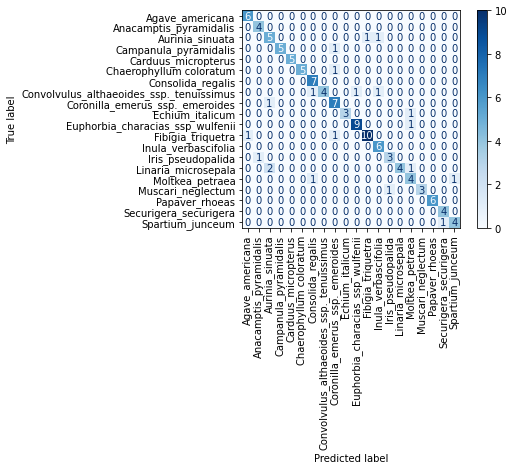

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

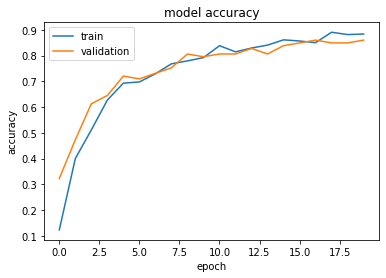

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

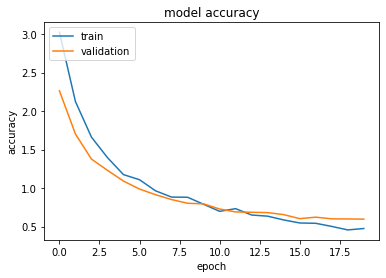

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()